<a href="https://colab.research.google.com/github/zenodante/AFMTools/blob/master/4DRAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training

This notebook takes the dataset we created in the last notebook and trains the machine learning model. 

<font color='green'>ACTION: create a folder called pytorchtest in your current working directory. </font>

## Import necessary packages

In [ ]:
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
import glob
import os

import torch
# import torchvision
# import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as D
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage import measure, filters
from sklearn.preprocessing import OneHotEncoder
print(torch.__version__)
import time

save_name = 'pytorchtest/firsttest' 

1.5.1


Next, load the dataset and reshape as necessary.  We save the dataset as a stack of 2D images, so the saved shape is (number of images x resolution x resolution), but pytorch needs a 4D datastack (number of images x number of layers/filters x resolution x resolution).  A 4D stack is needed when we use convolutional layers that increase the number of layers/filters at each level.

In [ ]:
!gdown --id 1q2m9HJnTb2Rovc4yoeKaXPkhfhcWMjEu
images = np.load('/content/sample_training.npy',mmap_mode='r+').reshape(-1,1,512,512)

In [ ]:
print(images[0].shape)

(1, 512, 512)


Blur helps with the segmentation of the images. However, sometimes blur can cause overfitting because all of the images look so similar. Training should first be attempted without adding blur to the images (skipping the following cell). If inference produces images with lots of small bright/dark spots, or segementation yeilds an unreasonably high number of particles, likely blur is needed to reduce the impact of image noise.

After applying blur you must renormalize the images. 

In [ ]:
images_blur = np.zeros_like(images) 
images.shape

def norm(im):
   return (im - np.min(im)) / (np.max(im) - np.min(im))

for i in range(len(images)):
   if i %1000 == 0:
       print(i)
   images[i] = norm(filters.gaussian(images[i],sigma=3)) 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


## First tunable param: Batch Size
The final line of the following cell sets the data up in a format that can be loaded into the CNN model.  When training any kind of ML model, the layer weights are adjusted based on the difference between the model output and the desired results (ground truth). For unsupervised learning, we are comparing the model output to the original image. 

Images are fed to the model in batch. A batch goes through the model in one pass, and the weights are adjusted based on the average performance on each image in the batch. This improves training speed and makes the model training/convergence smoother since we're adjusting based on mean performance rather than a single good or bad result.

You get the best performance making the batch size as large as your computer *(or GPU)* RAM can handle. Here we used 128 (meaning we process 128 images at a time), but on a standard laptop, you'd want probably 64 or even 32 for images of this size. 

In [ ]:
tensor_im = torch.stack([torch.Tensor(i) for i in images])
dataset = torch.utils.data.TensorDataset(tensor_im)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True)

## Initialize CNN Architectures

For a pytorch ML model, the initialization sets up all of the layers that you want available in your model. After each convolutional layer, we renormalize the image (`nn.BatchNorm(size)`). This normalization step is one of the most important in the whole process!

## Parameters to tune when defining a model: Convolutional Layer
A convolutional layer is defined with three main parameters:
1. the input dimension (how many layers in the input)
2. the output dimension (how many filters to apply to the input)
3. the kernel size (how large the trainable kernels or filters should be)

You can also set different values for stride, dilation, and padding, but we did not change these because it changes the shape of the image and can make it more difficult to fit consecutive layers together. The stride is how many pixels the filter moves over every time. Dilation is used to increase the size of the kernel which saves on memory. Lastly, padding adds 0's to the edge of an image.

### Input dimension
You can't change this parameter, but you need to set it every time.  In the first layer, this will be 1 since a grayscale image has only one layer.  In the next convolutional layer, the input dimension will be the output dimension of the previous layer.

### Output dimension
You set the number of filters that you want to act on the image at each step. More filters usually give better results, but risks overfitting -- memorizing the data rather than learning important features.  Using fewer filters risks underfitting -- learning some features, but not expressive enough to represent all of the data. The model starts with noisy filters and as it learns they become more defined. 

### Kernel Size
This is also called _receptive field_.  The kernel size determines how much of the image is viewed inside a single filter step.  Here we use a 7x7 kernel which means that we use a sliding window of 7x7 pixels to operate on the entire image.  Increasing the size of the kernel increases the number of pixels and the size of the area considered at any time. For large, high-resolution images , this is a good thing but, larger kernels require more memory which makes a model more difficult to train. In a deep network (multiple convolutional layers), you can balance what you gain from using more layers with what you gain from increasing the kernel size.

In [ ]:
class autoencoder_bottle_large_shallow(nn.Module):
    def __init__(self):
        super(autoencoder_bottle_large_shallow,self).__init__()
        self.conv0 = nn.Conv2d(1,2,7,dilation=1,padding=3)
        self.b0 = nn.BatchNorm2d(2)
        self.conv1 = nn.Conv2d(2,8,7,dilation=1,padding=3)
        self.b1 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8,2,7,stride=2,padding=3)
        self.b6 = nn.BatchNorm2d(2)
        self.conv7 = nn.ConvTranspose2d(2,1,7,stride=2,padding=3)
        self.b7 = nn.BatchNorm2d(1)
        self.pool = nn.MaxPool2d(2,2)

        
    def forward(self,x):
        c0 = self.pool(self.b0(F.relu(self.conv0(x))))
        c1 = self.pool(self.b1(F.relu(self.conv1(c0))))
        c6 = self.b6(F.relu(self.conv6(c1,output_size=c0.size())))
        c7 = self.b7(F.relu(self.conv7(c6,output_size=x.size())))  
        return c7

The `criterion` sets the loss function for the model to use. We use the loss function `MSELoss` for unsupervised learning to see how the output results are "scored" in comparison to the ground truth. MSE creates a criterion that measures the mean squared error (squared L2 norm) between each element in the input and target. 

The parameter `lr` is the learning rate. The learning rate determines how fast the model reacts to any wrong answers. A slower learning rate (lower number) makes smaller adjustments at each step and generally leads to better convergence, but if the learning rate is too slow the model can get stuck in local (not global) minima and it may never converge.

<font color='green'>ACTION (OPTIONAL): Can change learning rate. </font>

<font color='blue'>The line `device = torch.device('cuda:0,1,2,3' if torch.cuda.is_available() else 'cpu')` connects the model to your computer's GPU (graphics card). PyTorch only works with nvidia GPUs, so comment this line out if you don't have one. Similarly, `model = nn.DataParallel(model)` tells python to train using multiple GPUs. This line should be commented out if the computer you are running on only has 1 GPU.</font>

<font color='green'>ACTION (OPTIONAL): The first line of the following cell is where you can choose which model you use. </font>

In [ ]:
model = autoencoder_bottle_large_shallow()

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(),lr = 0.0005) 

device = torch.device('cuda:0,1,2,3' if torch.cuda.is_available() else 'cpu') 
print(device)
model.to(device)
model = nn.DataParallel(model) 

cuda:0


## Training routine

This cell defines the training process for iterating through all of the images and updating the model accordingly.

An epoch is one training iteration through the entire image set. One epoch runs through every batch in the dataset.
The number of epochs determines how long the training process continues. You could set to run as long as the loss is above a certain value.

We usually start with 20 epochs, because this gives good results but is still fast. Once we've tuned all the parameters the best we can, we increase the number of epochs by changing the number in range(). <font color='green'>ACTION (OPTIONAL): Can change number of epochs.</font>

We use `.backward` to determine which steps in the CNN generated significant errors and update the weights using the optimizer. The optimizer we use is called `Adam`. After a batch goes through the network the loss function calculates the differences between the output and ground truth (the input) and this difference goes into the optimizer. The weights are then updated using the optimizer. The goal is for the difference between them (the loss) to be close to 0. 

Ideally, the final plot with the loss value should converge to 0 because we want to minimize the difference between the output and input images. However, in practice, when using an unsupervised autoencoder, we want an imperfect reproduction of the input image. Therefore, the loss value should approach, yet never reach 0.

The example image below shows the segmentation and corresponding intensity histogram we are aiming for during training. 

<font color='blue'>The line `inputs = inputs.to(device)` sends the inputs to the GPU. Remove this if you are not using a GPU.</font> 

Epoch 1
loss: 0.0037923675211789334
Epoch time: 25.800036907196045

Epoch 2
loss: 0.002593222408003248
Epoch time: 25.788360834121704

Epoch 3
loss: 0.001769051086610859
Epoch time: 25.96931028366089

Finished Training
Total Time: 77.55849003791809


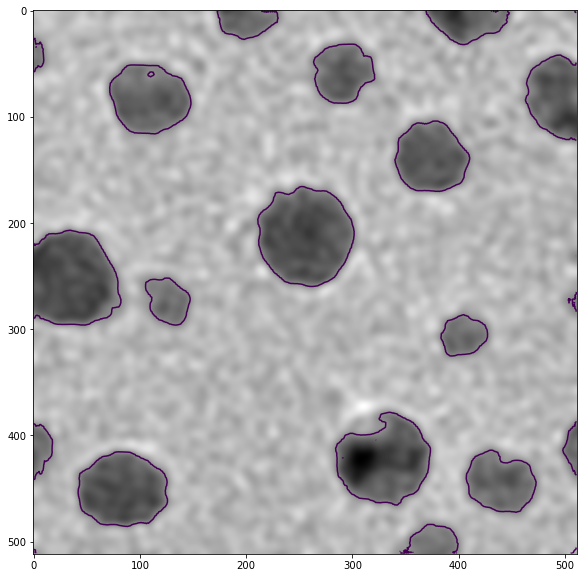

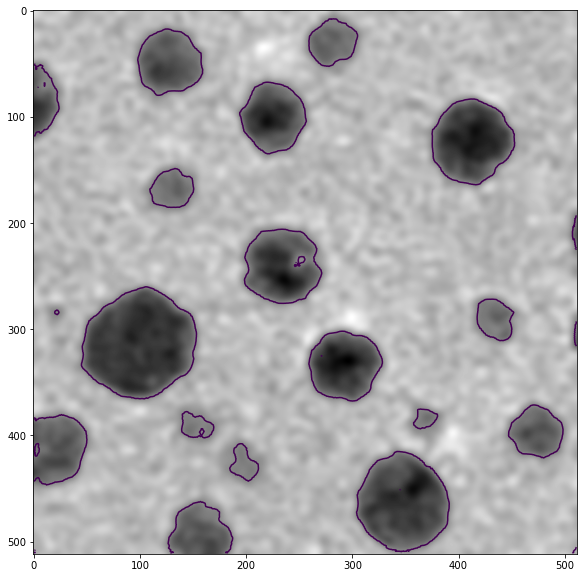

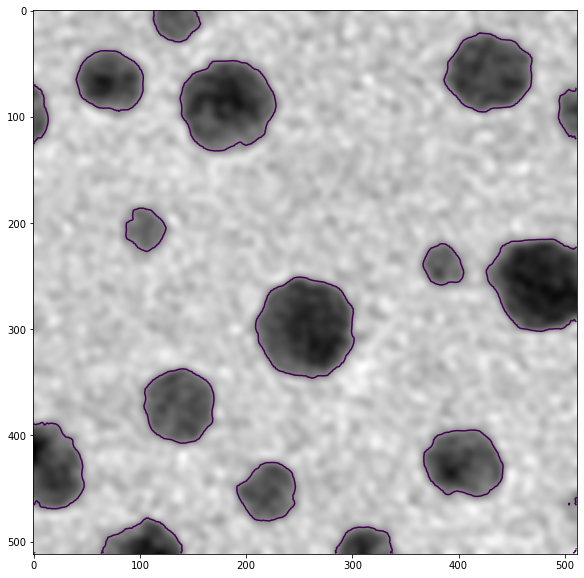

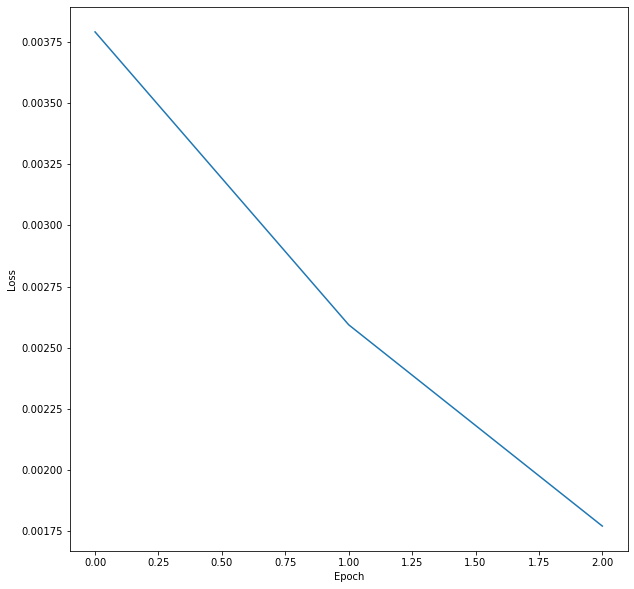

In [ ]:
loss_history = [] 

start = time.time() 
for epoch in range(3): 

    start_epoch = time.time()
    print('Epoch {}'.format(epoch+1))
    running_loss = 0.0
    n = 0
    
    for i, data in enumerate(dataloader,0):  
        inputs = data[0] 
        inputs = inputs.to(device) 
      
        optimizer.zero_grad()  
        outputs = model(inputs) 

        loss = criterion(outputs,inputs)  
        loss.backward() 
        optimizer.step() 
        
        running_loss += loss.item() 
    
    if (epoch + 1) % 1 == 0:  
        f,a = plt.subplots(ncols=1,figsize=(10,10))
        im = inputs.detach().cpu().numpy()[0,0,:,:]
        out = outputs.detach().cpu().numpy()[0,0,:,:]
#         if (epoch + 1) % 10 == 0:
        a.imshow(im,plt.cm.gray)
        a.contour(out.reshape(512,512),[filters.threshold_otsu(out)])  
        f.savefig(save_name+'_e{}.jpg'.format(epoch+1))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        },save_name+'_e{}.pt'.format(epoch+1))
        
        
    print('loss: {}'.format(running_loss/len(dataloader)))
    print('Epoch time: {}\n'.format(time.time() - start_epoch))
    loss_history.append(running_loss/len(dataloader))
        
print('Finished Training')
print('Total Time: {}'.format(time.time() - start))

### Plot loss vs epoch
f,a = plt.subplots(figsize=(10,10)) 
a.set_xlabel('Epoch') 
a.set_ylabel('Loss') 
a.plot(range(len(loss_history)),loss_history) 
f.savefig(save_name+'_Loss100.jpg')

## Training is Complete

The following steps run through a quick visualization of the results so that you can gauge the progress before applying the new model to all of the data in the next notebook.

The first plot is an image from the test set with an overlay of the detected image contours. The second plot is the full output of the CNN. The third plot is an intensity histogram and should have 2 peaks. The original data should be a normal distribution and the segmentation should make the data bimodal. The peak at lower values is close to black and represents the particles and the peak at higher values is close to white and represents the background. In general, the background peak will be larger than the particle peak. 

<font color='green'>ACTION (OPTIONAL): Can change the training images that you load for the test. Make sure to use the gaussian filter if you used it at the beginning of this notebook. </font>

<font color='blue'>The lines `test = test.detach().cpu().numpy()` and `test_out = test_out.detach().cpu().numpy()` take the images from the GPU back to the CPU. Remove this if training on a computer without Nvidia GPU. </font>

In [ ]:
!gdown --id 1Lelp1sSXeNtDpv0eIAnwak4dX4sGVb1T
test = np.load('/content/sample_data_small.npy',mmap_mode='r+')

for i in range(len(test)):
    test[i] = filters.gaussian(test[i],sigma=2)  #Only necessary if you did this to the data in the 2nd cell
    
test = torch.Tensor(test.reshape(-1,1,512,512))  
test_out = model(test) 

test = test.detach().cpu().numpy()  
test_out = test_out.detach().cpu().numpy()

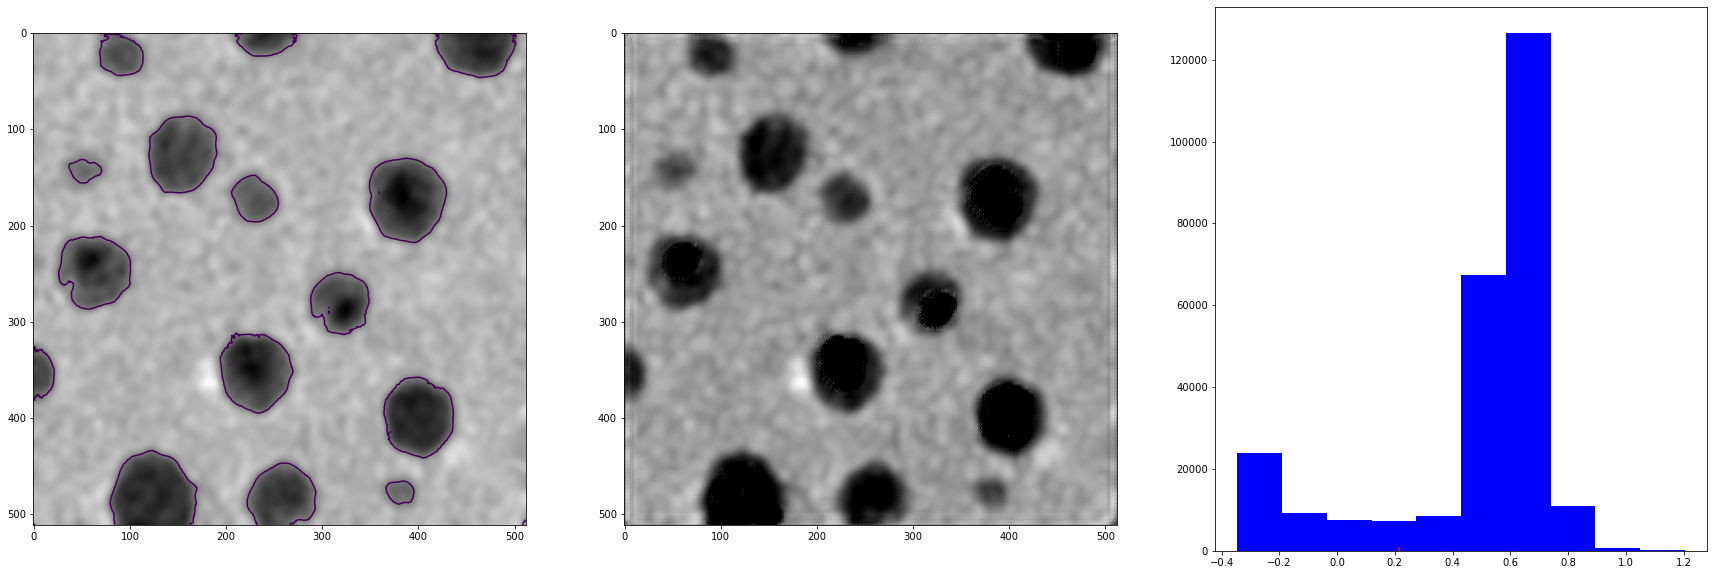

In [ ]:
n = int(np.random.rand()*len(test_out))  

f,a = plt.subplots(figsize=(30,10),ncols=3)  
a[0].imshow(test[n].reshape(512,512),plt.cm.gray) 
a[0].contour(test_out[n].reshape(512,512),[filters.threshold_otsu(test_out[n])])  

a[1].imshow(test_out[n].reshape(512,512),plt.cm.gray) 

a[2].hist(test_out[n].reshape(512*512),color='blue') 
a[2].vlines(filters.threshold_otsu(test_out[n]),ymin=0,ymax=1000,color='red') 

In [ ]:
print(test_out[0].shape)

(1, 512, 512)
